<a href="https://colab.research.google.com/github/CastHash532/kaggle-automl/blob/main/Kaggle_sentiment_NLP_fast_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!pip install fast-bert

     |████████████████████████████████| 99 kB 3.3 MB/s 
     |████████████████████████████████| 769 kB 39.4 MB/s 
     |████████████████████████████████| 3.0 MB 25.5 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 124 kB 43.8 MB/s 
     |████████████████████████████████| 895 kB 37.8 MB/s 
     |████████████████████████████████| 1.2 MB 35.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=4f65892cd02554773f53f62822bd63a10063ae583cab736c0362ff7e352362bf
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


## Authenticating with Kaggle using kaggle.json

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [ ]:
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

file_id = created.get('1m75pur070pfz3gcwUMNdVpjoXyM0Qghl')

import io
from googleapiclient.http import MediaIoBaseDownload

request = drive_service.files().get_media(fileId=file_id)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  # _ is a placeholder for a progress object that we ignore.
  # (Our file is small, so we skip reporting progress.)
  _, done = downloader.next_chunk()

downloaded.seek(0)
print('Downloaded file contents are: {}'.format(downloaded.read()))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

## Load data and preprocess



In [3]:
!kaggle datasets download -d kritanjalijain/amazon-reviews

 99% 1.28G/1.29G [00:08<00:00, 142MB/s]
100% 1.29G/1.29G [00:08<00:00, 161MB/s]


In [4]:
!ls

amazon-reviews.zip  sample_data


In [5]:
!unzip -u amazon-reviews.zip

Archive:  amazon-reviews.zip
  inflating: amazon_review_polarity_csv.tgz  
  inflating: test.csv                
  inflating: train.csv               


In [6]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('/content/train.csv', names=['label','text','add'])

In [7]:
dataset= dataset[0:5000]

In [8]:
dataset

,label,text,add
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
...,...,...,...
995,1,Fuzzy around the edges,I have only read the first 44 pages of this bo...
996,1,Brain Based Learning: The New Paradigm of Teac...,I am currently reading the Kindle version of t...
997,2,Brain based Learning,This is a text book I ordered for my classes f...
998,1,Pop psychology at its worst,I find it hard to believe people fall for this...


In [9]:
dataset['text'] = dataset['text'] + [' '] + dataset['add']
dataset.drop(['add'],axis=1,inplace=True)

In [10]:
dataset['label'] = dataset['label'].map(lambda x: 0 if x == 1 else 1)

In [11]:
from sklearn.model_selection import train_test_split

ds_train, ds_test = train_test_split(dataset,test_size=0.2, random_state=42)


In [12]:
text= 'text'
target='label'

In [13]:
# Take a subset of the News dataset and save it to csv files
ds_train.to_csv('/content/dtrain.csv')
ds_test.to_csv('/content/dtest.csv')

In [14]:
labels = [0,1]
pd.DataFrame(labels).to_csv('/content/labels.csv', index=False, header=False)

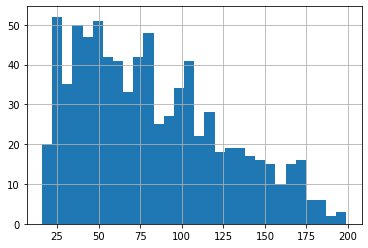

In [15]:
seq_len = [len(i.split()) for i in ds_train['text']]

pd.Series(seq_len).hist(bins = 30)

## Defining Model

In [16]:
from fast_bert.data_cls import BertDataBunch
import torch

DATA_PATH = LABEL_PATH = OUTPUT_PATH ='/content'

databunch = BertDataBunch(DATA_PATH, LABEL_PATH,
                          tokenizer='bert-base-uncased',
                          train_file='dtrain.csv',
                          val_file='dtest.csv',
                          label_file='labels.csv',
                          text_col=text,
                          label_col=target,
                          batch_size_per_gpu=32,
                          max_seq_length=256,
                          multi_gpu=True if torch.cuda.device_count() > 1 else False,
                          multi_label=False,
                          model_type='bert')

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [17]:

from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy
import logging


logger = logging.getLogger()
device_cuda = torch.device("cuda")
metrics = [{'name': 'accuracy', 'function': accuracy}]

learner = BertLearner.from_pretrained_model(
						databunch,
						pretrained_path='bert-base-uncased',
						metrics=metrics,
						device=device_cuda,
						logger=logger,
						output_dir=OUTPUT_PATH,
						finetuned_wgts_path=None,
						warmup_steps=500,
						multi_gpu=True if torch.cuda.device_count() > 1 else False,
						is_fp16=True,
						multi_label=False,
						logging_steps=50,
						freeze_transformer_layers=False
						)


Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

# Fine Tuning and Validation

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lamb/lamb.py:96: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Learning rate search finished. See the graph with {finder_name}.plot()


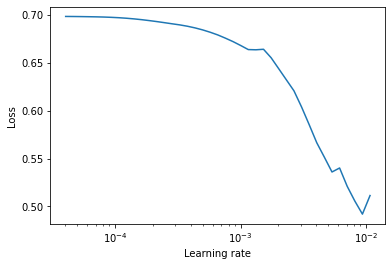

In [18]:
learner.lr_find(start_lr=1e-5,optimizer_type='lamb')

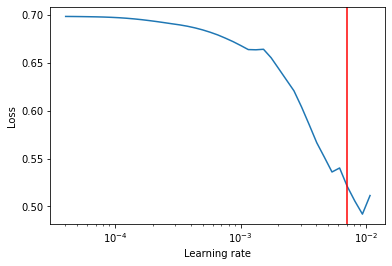

In [24]:
learner.plot(show_lr=7e-3)

In [25]:
#fine tuning the model
learner.fit(epochs=3,
			lr=8e-3,
			validate=True, 	# Evaluate the model after each epoch
			schedule_type="warmup_cosine",
			optimizer_type="lamb")


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/usr/local/lib/python3.7/dist-packages/fast_bert/learner_cls.py:357: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  self.model.parameters(), self.max_grad_norm


(75, 0.44702189445495605)

In [26]:
learner.validate()

{'accuracy': 0.915, 'loss': 0.182474825065583}